In [1]:
# ------------------------------------------------------
# Refined Double Descent Experiment with BERTScore


In [2]:
# ------------------------------------------------------

# ✅ Imports and Setup
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from bert_score import score as bertscore
import random
import re
import requests



C:\Users\jonat\anaconda3\envs\gpt2env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ------------------------------------------------------
# Step 1: Data Loading and Preprocessing


In [4]:
# ------------------------------------------------------

# Download and clean Alice in Wonderland
url = "https://www.gutenberg.org/files/11/11-0.txt"
response = requests.get(url)
raw_text = response.text.lower()
raw_text = re.sub(r"[^a-z\s]", "", raw_text)
words = raw_text.split()

# Limit vocabulary for controlled complexity
def build_tokenizer(words, vocab_size):
    most_common = [w for w, _ in Counter(words).most_common(vocab_size - 1)]
    vocab = ["<UNK>"] + most_common
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for w, i in word2idx.items()}

    def encode(text):
        return [word2idx.get(w, word2idx["<UNK>"]) for w in text]

    def decode(indices):
        return " ".join([idx2word[i] for i in indices])

    return vocab, word2idx, idx2word, encode, decode



In [5]:
# ------------------------------------------------------
# Step 2: Dataset Builder


In [6]:
# ------------------------------------------------------

class WordDataset(Dataset):
    def __init__(self, encoded, seq_len=5):
        self.xs = []
        self.ys = []
        for i in range(len(encoded) - seq_len):
            self.xs.append(torch.tensor(encoded[i:i+seq_len]))
            self.ys.append(torch.tensor(encoded[i+seq_len]))

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]



In [7]:
# ------------------------------------------------------
# Step 3: GRU Language Model


In [8]:
# ------------------------------------------------------

class GRULanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        _, h = self.gru(x)
        out = self.fc(h.squeeze(0))
        return out



In [9]:
# ------------------------------------------------------
# Step 4: GPT-2 and BERTScore Setup


In [10]:
# ------------------------------------------------------

gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_model.eval()

def gpt2_score(sentence):
    inputs = gpt2_tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = gpt2_model(**inputs, labels=inputs["input_ids"])
    return outputs.loss.item()



In [11]:
# ------------------------------------------------------
# Step 5: Experiment Loop with Extended Epochs and BERT


In [12]:
# ------------------------------------------------------

# Configuration
seq_len = 5
train_size = 10000
test_size = 1000
batch_size = 64
epochs = 15

# Extended model complexity grid
complexities = [(4, 8), (8, 16), (16, 32), (24, 48), (32, 64), (48, 96), (64, 128)]

results = []

for embed_dim, hidden_dim in complexities:
    vocab_size = 1000
    vocab, word2idx, idx2word, encode, decode = build_tokenizer(words, vocab_size)
    encoded = encode(words)

    train_data = encoded[:train_size + seq_len]
    test_data = encoded[train_size:train_size + test_size + seq_len]

    train_ds = WordDataset(train_data, seq_len)
    test_ds = WordDataset(test_data, seq_len)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=1)

    model = GRULanguageModel(vocab_size, embed_dim, hidden_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        for x, y in train_loader:
            preds = model(x)
            loss = criterion(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    gpt2_losses = []
    bert_f1s = []

    for x, y in test_loader:
        with torch.no_grad():
            logits = model(x)
            pred_id = torch.argmax(logits, dim=-1).item()
            input_ids = x.squeeze().tolist()
            true_word = idx2word[y.item()]
            pred_word = idx2word[pred_id]
            input_words = [idx2word[i] for i in input_ids]
            true_sent = " ".join(input_words + [true_word])
            pred_sent = " ".join(input_words + [pred_word])

            gpt2_losses.append(gpt2_score(pred_sent))
            _, _, f1 = bertscore([pred_sent], [true_sent], lang="en", verbose=False)
            bert_f1s.append(f1.item())

    avg_gpt2 = np.mean(gpt2_losses)
    avg_bert = np.mean(bert_f1s)
    param_count = sum(p.numel() for p in model.parameters())

    results.append((param_count, avg_gpt2, avg_bert))
    print(f"✅ embed={embed_dim}, hidden={hidden_dim}, params={param_count}, GPT-2={avg_gpt2:.4f}, BERTScore={avg_bert:.4f}")



`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model ch

✅ embed=4, hidden=8, params=13336, GPT-2=5.8291, BERTScore=0.9441


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

✅ embed=8, hidden=16, params=26248, GPT-2=5.9909, BERTScore=0.9448


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

✅ embed=16, hidden=32, params=53800, GPT-2=6.0528, BERTScore=0.9454


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

✅ embed=24, hidden=48, params=83656, GPT-2=6.0619, BERTScore=0.9466


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

✅ embed=32, hidden=64, params=115816, GPT-2=6.0811, BERTScore=0.9457


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

✅ embed=48, hidden=96, params=187048, GPT-2=6.0476, BERTScore=0.9464


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

✅ embed=64, hidden=128, params=267496, GPT-2=6.1271, BERTScore=0.9453


In [13]:
# ------------------------------------------------------
# Step 6: Plot GPT-2 Loss and BERTScore Curves


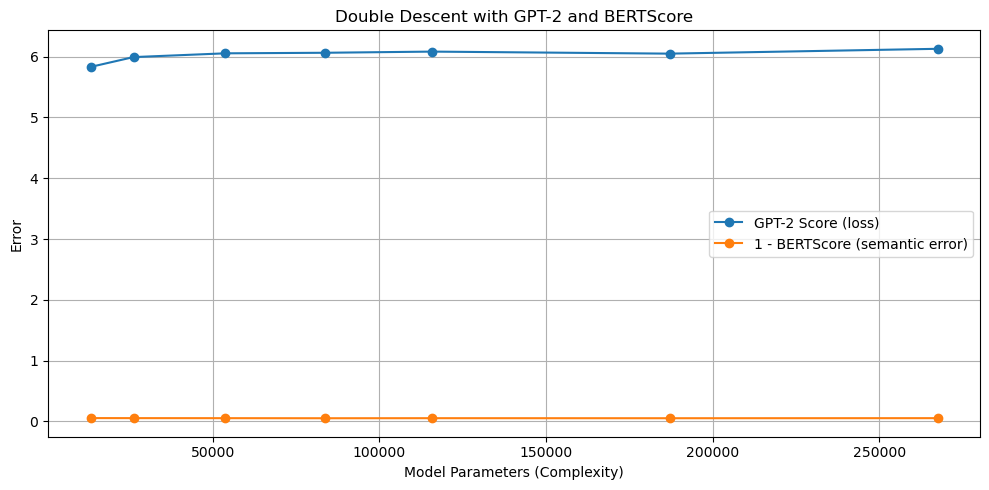

In [14]:
# ------------------------------------------------------

param_counts, gpt2_scores, bert_scores = zip(*results)

plt.figure(figsize=(10, 5))
plt.plot(param_counts, gpt2_scores, marker='o', label='GPT-2 Score (loss)')
plt.plot(param_counts, [1 - b for b in bert_scores], marker='o', label='1 - BERTScore (semantic error)')
plt.xlabel("Model Parameters (Complexity)")
plt.ylabel("Error")
plt.title("Double Descent with GPT-2 and BERTScore")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
